In [83]:
import tensorflow as tf
import os
import cv2
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam

from flask import Flask, request, jsonify

import matplotlib.pyplot as plt
from mysql.connector import Error

!pip install mysql-connector-python
import mysql.connector


[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [84]:
def load_and_train_model():
    model = Sequential()

    model.add(Conv2D(16, (3, 3), 1, activation='relu', input_shape=(256, 256, 3)))
    model.add(MaxPooling2D())
    model.add(Conv2D(32, (3, 3), 1, activation='relu'))
    model.add(MaxPooling2D())
    model.add(Conv2D(16, (3, 3), 1, activation='relu'))
    model.add(MaxPooling2D())
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dense(4, activation='softmax'))

    model.compile(optimizer=Adam(), loss=SparseCategoricalCrossentropy(), metrics=['accuracy'])

    logdir = 'logs'
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)
    
    data = tf.keras.utils.image_dataset_from_directory('data')

    data_iterator = data.as_numpy_iterator()

    batch = data_iterator.next()

    fig, ax = plt.subplots(ncols=4, figsize=(20,20))
    for idx, img in enumerate(batch[0][:4]):
        ax[idx].imshow(img.astype(int))
        ax[idx].title.set_text(batch[1][idx])

    data = data.map(lambda x,y: (x/255, y))

    data.as_numpy_iterator().next()

    train_size = int(len(data)*.7)
    val_size = int(len(data)*.2)
    test_size = int(len(data)*.1)

    train_size

    train = data.take(train_size)
    val = data.skip(train_size).take(val_size)
    test = data.skip(train_size+val_size).take(test_size)

    train

    model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

    return model

In [85]:
# Function to create a connection to MySQL database
def create_connection():
    try:
        connection = mysql.connector.connect(
            host='localhost',
            user='root',
            password='Greftumgri1.23',
            database='andradb'
        )
        if connection.is_connected():
            print("Connected to MySQL database")
            return connection
    except Error as e:
        print(f"Error: {e}")
        return None

In [86]:
# Function to insert a new class into the database
def insert_class(cursor, class_name):
    try:
        cursor.execute(f"INSERT INTO CLASS (NAME) VALUES ('{class_name}')")
    except Error as e:
        print(f"Error inserting class: {e}")

In [113]:
# Function to insert a new image into the database
def insert_image(cursor, file_name, file_path):
    try:
        cursor.execute(f"INSERT INTO IMAGE (FILE_NAME, FILE_PATH) VALUES ('{file_name}', '{file_path}')")
        
        return cursor.lastrowid
    except Error as e:
        print(f"Error inserting image: {e}")
        return None


In [88]:
# Function to insert a new classification into the database
def insert_classification(cursor, image_id, class_id):
    try:
        cursor.execute(f"INSERT INTO CLASSIFICATION (IMAGE_ID, CLASS_ID) VALUES ({image_id}, {class_id})")
    except Error as e:
        print(f"Error inserting classification: {e}")


In [89]:
def preprocess_image(image_path):
    img = cv2.imread(image_path)
    resized_img = tf.image.resize(img, (256, 256))
    return resized_img

In [97]:
# Function to preprocess and classify an image
def classify_image(model, image_path, cursor):
    try:
        # Read and preprocess the image
        img = preprocess_image(image_path)
        
        # Make predictions
        yhat = model.predict(np.expand_dims(img / 255, 0))
        predicted_class = np.argmax(yhat) + 1

        # Get class names
        class_names = {
            1: 'Class1',
            2: 'Class2',
            3: 'NEWSPAPER',
            4: 'unknown'
            # Add more class indices and names as needed
        }

        predicted_class_name = class_names.get(predicted_class, f'UnknownClass_{predicted_class}')

        # Insert results into the database
        insert_class(cursor, predicted_class_name)
        image_id = insert_image(cursor, os.path.basename(image_path), image_path)
        print(f"image id is {image_id}")
        insert_classification(cursor, image_id, predicted_class)

        return predicted_class_name

    except Exception as e:
        print(f"Error during classification: {e}")
        return None

In [98]:
# Function to preprocess an image
def preprocess_image(image_path):
    img = cv2.imread(image_path)
    resized_img = tf.image.resize(img, (256, 256))
    return resized_img

# Function to train the model
def train_model():
    # ... (your existing training code)
    logdir='logs'
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)
    hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

# Function to evaluate the model
def evaluate_model(test_data):
    # ... (your existing evaluation code)
    from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy
    pre = Precision()
    re = Recall()
    acc = BinaryAccuracy()
    
    for batch in test.as_numpy_iterator(): 
        X, y = batch
        yhat = model.predict(X)
        pre.update_state(y, yhat)
        re.update_state(y, yhat)
        acc.update_state(y, yhat)
    
    print(pre.result(), re.result(), acc.result())
    

In [99]:
def query_class_characteristics(cursor, class_name):
    try:
        # SQL query to retrieve class characteristics
        query = """
        SELECT m.name AS material, c.name AS component, ch.percentage
        FROM class cl
        INNER JOIN class_characteristic cc ON cl.class_id = cc.class_id
        INNER JOIN characteristic ch ON cc.characteristic_id = ch.characteristic_id
        INNER JOIN material m ON ch.material_id = m.material_id
        INNER JOIN component c ON ch.component_id = c.component_id
        WHERE cl.name = %s
        """

        # Execute the query with the class name as parameter
        cursor.execute(query, (class_name,))
        
        # Fetch all the results
        rows = cursor.fetchall()
        
        # Format the retrieved data into JSON format
        class_data = []
        for row in rows:
            material = row[0]
            component = row[1]
            percentage = row[2]
            class_data.append({"material": material, "component": component, "percentage": percentage})

        return class_data
    
    except Error as e:
        print(f"Error querying class characteristics: {e}")
        return None

In [100]:
# Extra test for JSON 
# Get a database connection
#connection = create_connection()

#if connection:
#    try:
        # Your existing code here to initialize the cursor
        #cursor = connection.cursor()
        
       #class_characteristics = query_class_characteristics(cursor, "NEWSPAPER")
       # if class_characteristics:
            #print("Class Characteristics:")
           # for char in class_characteristics:
             #   print(char)
       # else:
            #print("No characteristics found for the class.")
            
    #finally:
       # cursor.close()
       # connection.close()
       # print("Connection closed")
#else:
   # print("Failed to establish a connection to the database.")

Connected to MySQL database
No characteristics found for the class.
Connection closed


In [101]:
# Function to display an image
def show_image(file_path):
    img = cv2.imread(file_path)
    if img is not None:
        plt.imshow(img)
        plt.show()
    else:
        print(f"Error: Unable to read image from file '{file_path}'.")

Found 391 files belonging to 4 classes.
Epoch 1/20
9/9 [==============================] - 8s 665ms/step - loss: 2.2458 - accuracy: 0.2500 - val_loss: 1.3983 - val_accuracy: 0.2188
Epoch 2/20
9/9 [==============================] - 7s 649ms/step - loss: 1.3353 - accuracy: 0.3854 - val_loss: 1.2901 - val_accuracy: 0.3438
Epoch 3/20
9/9 [==============================] - 7s 650ms/step - loss: 1.2509 - accuracy: 0.3819 - val_loss: 1.1128 - val_accuracy: 0.4219
Epoch 4/20
9/9 [==============================] - 7s 654ms/step - loss: 1.0651 - accuracy: 0.5312 - val_loss: 0.8353 - val_accuracy: 0.7812
Epoch 5/20
9/9 [==============================] - 7s 667ms/step - loss: 0.8633 - accuracy: 0.6736 - val_loss: 0.7891 - val_accuracy: 0.7188
Epoch 6/20
9/9 [==============================] - 7s 665ms/step - loss: 0.7132 - accuracy: 0.7257 - val_loss: 0.5933 - val_accuracy: 0.8281
Epoch 7/20
9/9 [==============================] - 7s 677ms/step - loss: 0.6431 - accuracy: 0.7361 - val_loss: 0.6190 - v

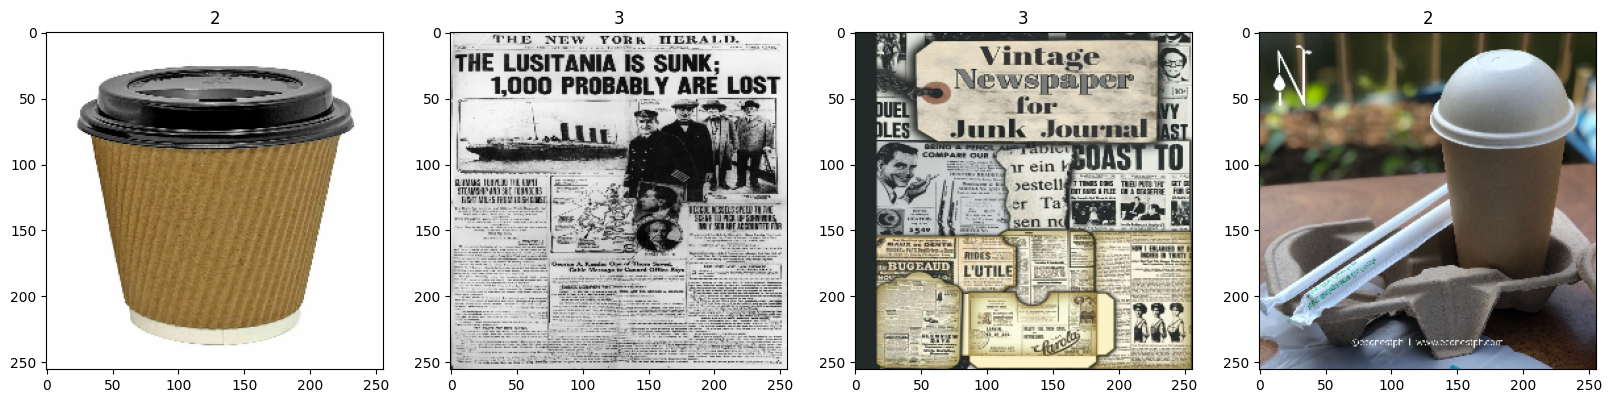

In [102]:
model = load_and_train_model()

In [107]:
def select_all_from_class_table(cursor):
    try:
        # Query to select all columns from the class table
        cursor.execute("SELECT * FROM CLASS")
        
        # Fetch all rows from the result
        rows = cursor.fetchall()
        
        # Display the rows
        for row in rows:
            print(row)
    
    except Error as e:
        print(f"Error selecting from CLASS table: {e}")


In [ ]:
app = Flask(__name__)

In [ ]:
# Define a route for model training
@app.route('/train_model', methods=['GET'])
def train_model_route():
    model = load_and_train_model()
    return "Model trained successfully."

In [ ]:
# Define a route for image classification
@app.route('/classify_image', methods=['POST'])
def classify_image_route():
    # Get image file from request
    file = request.files['image']
    file_path = 'temp.jpg'
    file.save(file_path)

    # Load the trained model
    model = load_and_train_model()

    # Get a database connection
    connection = create_connection()

    if connection:
        try:
            cursor = connection.cursor()
            
            # Example usage with a variable containing the file path
            result = classify_image(model, file_path, cursor)

            if result:
                print(f"Predicted class: {result}")

                # Query for class characteristics
                class_characteristics = query_class_characteristics(cursor, result)
                if class_characteristics:
                    print("Class Characteristics:")
                    for char in class_characteristics:
                        print(char)
                else:
                    print("No characteristics found for the class.")

        finally:
            connection.commit()
            cursor.close()
            connection.close()
            print("Connection closed")

        return jsonify({'prediction': result})

In [ ]:
# Run Flask app
if __name__ == '__main__':
    app.run(debug=True)

Connected to MySQL database
(1, 'Coffee_Cups')
(2, 'Aluminium_Cans')
(3, 'Cartons')
(4, 'Newspapers')
(5, 'NewClass')
(6, 'Class2')
(7, 'Class2')
(8, 'Class2')
(9, 'Class2')
(10, 'Class1')
(11, '1')
(12, 'Class1')
(13, 'NEWSPAPERRR')
(14, 'NEWSPAPERRR')
(15, 'NewClass')
(16, 'NEWSPAPER')
(30, 'unknown')
(31, 'unknown')
(32, 'unknown')
1/1 [==============================] - 0s 19ms/step
image id is 29
Predicted class: unknown


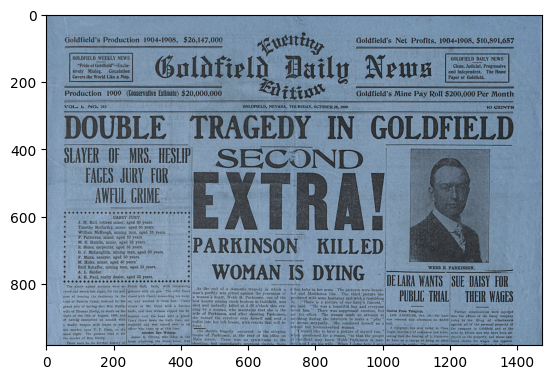

No characteristics found for the class.
Connection closed


In [116]:
# Example usage without Flask
if __name__ == "__main__":
    # Your existing code here to load and train the model

    # Get a database connection
    connection = create_connection()
    
    if connection:
        try:
            # Your existing code here to initialize the cursor
            cursor = connection.cursor()
            select_all_from_class_table(cursor)


            # Example usage with a variable containing the file path
            image_path_variable = 'newspaper_test.jpg'
            result = classify_image(model, image_path_variable, cursor)

            if result:
                print(f"Predicted class: {result}")
                show_image(image_path_variable)
                
                                # Query for class characteristics
                class_characteristics = query_class_characteristics(cursor, result)
                if class_characteristics:
                    print("Class Characteristics:")
                    for char in class_characteristics:
                        print(char)
                else:
                    print("No characteristics found for the class.")

        finally:
            connection.commit()
            cursor.close()
            connection.close()
            print("Connection closed")